<a href="https://colab.research.google.com/github/robinvloeberghs/slow_drift_correction/blob/main/Hierarchical_Bernoulli_LDS_with_PG_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Bernoulli LDS with PG Augmentation

This notebook implements a hierarchical Bernoulli LDS model with a Gibbs sampling algorithm for Bayesian inference using Pólya-gamma (PG) augmentation.

## Setup

In [ ]:
%%capture
!pip install equinox
!pip install blackjax

In [ ]:
import blackjax
import equinox as eqx

import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from fastprogress import progress_bar
from jax import grad, jit, lax, vmap
from jax.nn import sigmoid
from jaxtyping import Float, Array, Int
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Model

Let
- $N$ denote the number of subjects
- $T_i$ denote the length of the $i$-th subject (number of trials)
- $\theta_i = (a_i, w_i, \varsigma_i^2)$ denote the **local parameters** for trial $i$
- $\eta = (a_0, \nu_a^2, w_0, \nu_w^2, \alpha, \beta)$ denote the **global parameters**.
- $x_{i,t} \in \mathbb{R}$ for $t \in 1,\ldots,T_i$ denote the **latent states** on trial $i$.
- $u_{i,t} \in \mathbb{R}^p$ for $t \in 1,\ldots,T_i$ denote the **inputs** on trial $i$.
- $y_{i,t} \in \{0,1\}$ for $t \in 1,\ldots,T_i$denote the **binary observations** on trial $i$.

## Model
The joint distribution is,
\begin{multline*}
p(\{x_i, y_i, \theta_i\}_{i=1}^N \mid \{u_i\}_{i=1}^N, \eta)
= \\
p(\eta) \prod_{i=1}^N p(\theta_i \mid \eta)
\times \left[ \mathrm{N}(x_{i,1} \mid 0, 1) \prod_{t=2}^{T_i} \mathrm{N}(x_{i,t} \mid a_i x_{i,t-1}, \varsigma_{i}^2) \right] \\
\times \left[\prod_{t=1}^{T_i} \mathrm{Bern}\left(y_{i,t} \mid \sigma(x_{i,t} + w_i^\top u_{i,t}) \right) \right]
\end{multline*}

where
\begin{align*}
p(\theta_i \mid \eta)
&= \mathrm{TruncNorm}(a_i \mid a_0, \nu_a^2, [0,1]) \, \mathrm{N}(w_i \mid w_0, \nu_w^2 I) \, \mathrm{IGa}(\varsigma_i^2 \mid \alpha, \beta)
\end{align*}

\\

### Model Components:
- $p(\theta_i \mid \eta)$: The prior distribution of local parameters $\theta_i$ given global parameters $\eta$. It involves three distributions:

  - $\mathrm{TruncNorm}(a_i \mid a_0, \nu_a^2, [0,1])$: Truncated Normal distribution for $a_i$.
  - $\mathrm{N}(w_i \mid w_0, \nu_w^2 I)$: Multivariate Normal distribution for $w_i$.
  -$\mathrm{IGa}(\varsigma_i^2 \mid \alpha, \beta)$: Inverse Gamma distribution for $\varsigma_i^2$.

- Latent State Dynamics: Described by the term $\mathrm{N}(x_{i,1} \mid 0, 1)$ (initial state) and a dynamic transition from $x_{i,t-1}$ to $x_{i,t}$.

- Delta Function Term: $\delta_0\left( \frac{1}{T_i} \sum_{t=1}^{T_i} x_{i,t} \right)$ ensures that the latent states are centered on each trial, making the intercept term in $w_i$ identifiable.

- Observation Model: $\mathrm{Bern}\left(y_{i,t} \mid \sigma(x_{i,t} + w_i^\top u_{i,t}) \right)$ represents a Bernoulli distribution for binary observations, where the probability is determined by a logistic function of the latent state and input.

\\

The delta function in the joint distribution ensures that the latent states are centered on each trial so that the intercept term in $w_i$ is identifiable.

We'll perform inference using Pólya-gamma augmentation. See below.

In [ ]:
class HierarchicalBernoulliLDS(eqx.Module):
    r"""
    Implementation of the model.
    """
    w_0       : Float[Array, "num_inputs"]   # mean input weights
    logit_a_0 : Float = 10.0                 # a_0 in unconstrained form (always HMC on unconstrained values)
    log_nu_a  : Float = -1.0                 # \nu_a in unconstrained form (small value)
    log_nu_w  : Float = -1.0                 # mean input weights
    log_alpha : Float = 1.0                  # shape of inverse gamma prior
    log_beta  : Float = 1.0                  # scale of inverse gamma prior

    def __init__(self, a_0, nu_a, w_0, nu_w, alpha, beta):
        self.logit_a_0 = jax.scipy.special.logit(a_0)
        self.log_nu_a = jnp.log(nu_a)
        self.w_0 = w_0
        self.log_nu_w = jnp.log(nu_w)
        self.log_alpha = jnp.log(alpha)
        self.log_beta = jnp.log(beta)

    def sample(self,
               key,
               inputs : Float[Array, "num_trials num_timesteps num_inputs"]
               ):
        r"""
        Draw a sample from the generative model.
        """
        num_trials, num_timesteps, num_inputs = inputs.shape
        assert num_inputs == self.w_0.shape[0]

        def _sample_one(key, u_i):
            k1, k2, k3, k4, k5, k6 = jr.split(key, 6)

            # Sample per trial parameters
            a_i = tfd.TruncatedNormal(sigmoid(self.logit_a_0),
                                      jnp.exp(self.log_nu_a),
                                      0.0, 1.0).sample(seed=k1)
            w_i = tfd.Normal(self.w_0, jnp.exp(self.log_nu_w)).sample(seed=k2)
            sigmasq_i = tfd.InverseGamma(jnp.exp(self.log_alpha),
                                         jnp.exp(self.log_beta)).sample(seed=k3)

            # Sample latent states
            x_i0 = tfd.Normal(0, 1).sample(seed=k4)
            def _step(x_it, key):
                x_itp1 = tfd.Normal(a_i * x_it, jnp.sqrt(sigmasq_i)).sample(seed=key)
                return x_itp1, x_it
            _, x_i = lax.scan(_step, x_i0, jr.split(k5, num_timesteps))

            # Ensure the latent states are centered
            x_i -= x_i.mean()

            # Sample emissions
            y_i = tfd.Bernoulli(x_i + u_i @ w_i).sample(seed=k6)
            return dict(a=a_i, w=w_i, sigmasq=sigmasq_i), x_i, y_i

        return vmap(_sample_one)(jr.split(key, num_trials), inputs)

    def log_prob(self,
                 emissions : Float[Array, "num_trials num_timesteps"],
                 masks : Float[Array, "num_trials num_timesteps"],
                 states : Float[Array, "num_trials num_timesteps"],
                 inputs : Float[Array, "num_trials num_timesteps num_inputs"],
                 params : dict):
        lp = 0.0

        def _single_lp(y_i, m_i, x_i, u_i, params_i):
            a_i = params_i["a"]
            w_i = params_i["w"]
            sigma_i = jnp.sqrt(params_i["sigmasq"])

            # \log p(\theta_i | \eta)
            lp_i = tfd.TruncatedNormal(sigmoid(self.logit_a_0),
                                       jnp.exp(self.log_nu_a),
                                       0.0, 1.0).log_prob(a_i)
            lp_i += tfd.Normal(self.w_0, jnp.exp(self.log_nu_w)).log_prob(w_i)
            lp_i += tfd.InverseGamma(jnp.exp(self.log_alpha),
                                     jnp.exp(self.log_beta)).log_prob(sigma_i**2)

            # \log p(x_i | \theta_i)
            lp_i += tfd.Normal(0, 1).log_prob(x_i[0])
            lp_i += tfd.Normal(a_i * x_i[:-1], sigma_i).log_prob(x_i[1:]).sum()

            # \log p(y_i | x_i, u_i, \theta_i)
            lp_i += jnp.sum(m_i * tfd.Bernoulli(x_i + u_i @ w_i).log_prob(y_i)) # m_i is mask (if 0 then just sum 0)
            return lp_i

        return vmap(_single_lp)(emissions, masks, states, inputs, params).sum()

### Generate simulated data

In [ ]:
key = jr.PRNGKey(1)

num_inputs = 4
num_trials = 100
num_timesteps = 500

k1, k2 = jr.split(key)
w0 = jnp.array([0.0, 0.5, -0.3, 0.7])       # Generate data with nonzero mean effects
nu_w = 0.1
true_model = HierarchicalBernoulliLDS(0.90, 0.01, w0, nu_w, 20.0, 20.0 * 0.2**2)
inputs = tfd.Normal(0, 1).sample(sample_shape=(num_trials, num_timesteps, num_inputs), seed=k1)
inputs = inputs.at[:, :, 0].set(1.0)
true_params, true_states, emissions = true_model.sample(key, inputs)
masks = jnp.ones_like(emissions)
true_lp = true_model.log_prob(emissions, masks, true_states, inputs, true_params)

print(true_params["a"].shape)
print(true_params["w"].shape)
print(true_params["sigmasq"].shape)
print(true_states.shape)
print(emissions.shape)
print(true_lp / emissions.size)

(100,)
(100, 4)
(100,)
(100, 500)
(100, 500)
-1.6902995


In [ ]:
print(true_params["a"][:10])
print(jnp.sqrt(true_params["sigmasq"])[:10])

[0.97972214 0.9795956  0.9939295  0.99419075 0.9895019  0.97068536
 0.9906226  0.98229945 0.99667114 0.9861377 ]
[0.2434471  0.20348418 0.2228432  0.21958466 0.1988931  0.21487598
 0.20626809 0.21987717 0.18540159 0.20515904]


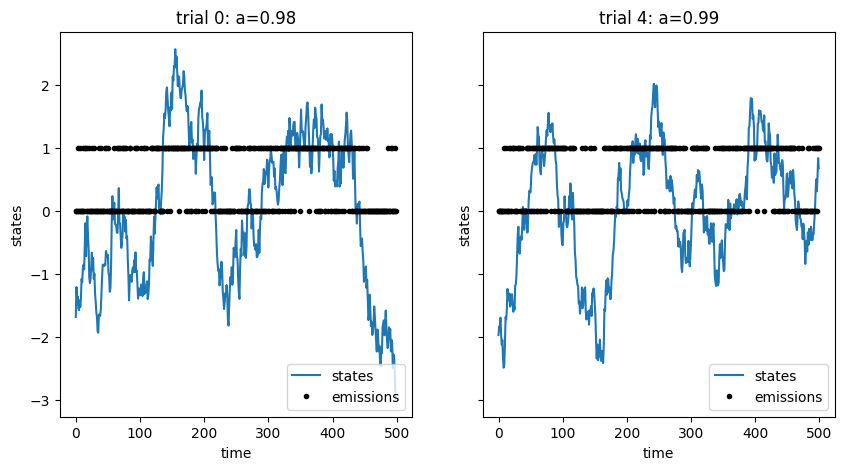

In [ ]:
# Plot one trial
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, ax in zip([0, 4], axs):
    ax.plot(true_states[i], label="states")
    ax.plot(emissions[i], 'k.', label="emissions")
    ax.set_xlabel("time")
    ax.set_ylabel("states")
    ax.legend(loc="lower right")
    ax.set_title(r"trial {:d}: a={:.2f}".format(i, true_params["a"][i]))

## Inference



### Sampling the latent states
The trick is to represent the Bernoulli likelihood as a scale-mean mixture of Gaussians using the PG augmentation,

\begin{align}
\mathrm{Bern}(y \mid \sigma(\psi))
&\propto e^{(y - \frac{1}{2}) \psi} \int e^{-\frac{1}{2} \omega \psi^2} \, \mathrm{PG}(\omega \mid 1, 0) \, \mathrm{d} \omega.
\end{align}

In our case, $\psi_{it} = x_{it} + w_i^\top u_{it}$. After augmenting the model with auxiliary variables $\omega_{it}$, the log likelihood as a function of $x_{it}$ is,
\begin{align}
\log p(y_{it} \mid x_{it}, \omega_{it}, u_{it}, \theta_i)
&=
h_{it} x_{it}
- \frac{1}{2} \omega_{it} x_{it}^2
\end{align}
where $h_{it} = y_{it} - \omega_{it} w_i^\top u_{it} - \frac{1}{2}$ is the precision-weighted mean, which we recognize as the centered residual.

The log likelihoods are quadratic, which means they are conjugate with the linear Gaussian dynamical system for $x_i$. We can use information-form message passing algorithms to sample the latent states from their conditional distribution given the emissions, inputs, parameters, and auxiliary PG variables.

In [ ]:
# @title Helper functions for information form message passing
from jax.scipy.linalg import solve_triangular

def lds_info_filter(J_diag, J_lower_diag, h):
    """ Information form filtering for a linear Gaussian dynamical system.
    """
    # extract dimensions
    num_timesteps, dim, _ = J_diag.shape

    # Pad the L's with one extra set of zeros for the last predict step
    J_lower_diag_pad = jnp.concatenate((J_lower_diag, jnp.zeros((1, dim, dim))), axis=0)

    def marginalize(carry, t):
        Jp, hp, lp = carry

        # Condition
        Jc = J_diag[t] + Jp
        hc = h[t] + hp

        # Predict (using Cholesky)
        sqrt_Jc = jnp.linalg.cholesky(Jc)
        trm1 = solve_triangular(sqrt_Jc, hc, lower=True)
        trm2 = solve_triangular(sqrt_Jc, J_lower_diag_pad[t].T, lower=True)
        log_Z = 0.5 * dim * jnp.log(2 * jnp.pi)
        log_Z += -jnp.sum(jnp.log(jnp.diag(sqrt_Jc)))  # sum these terms only to get approx log|J|
        log_Z += 0.5 * jnp.dot(trm1.T, trm1)
        Jp = -jnp.dot(trm2.T, trm2)
        hp = -jnp.dot(trm2.T, trm1)

        # Alternative predict step:
        # log_Z = 0.5 * dim * np.log(2 * np.pi)
        # log_Z += -0.5 * np.linalg.slogdet(Jc)[1]
        # log_Z += 0.5 * np.dot(hc, np.linalg.solve(Jc, hc))
        # Jp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, J_lower_diag_pad[t].T))
        # hp = -np.dot(J_lower_diag_pad[t], np.linalg.solve(Jc, hc))

        new_carry = Jp, hp, lp + log_Z
        return new_carry, (Jc, hc)

    # Initialize
    Jp0 = jnp.zeros((dim, dim))
    hp0 = jnp.zeros((dim,))
    (_, _, log_Z), (filtered_Js, filtered_hs) = \
        lax.scan(marginalize, (Jp0, hp0, 0), jnp.arange(num_timesteps))
    return log_Z, filtered_Js, filtered_hs

def _sample_info_gaussian(key, J, h, sample_shape=()):
    # TODO: avoid inversion.
    # see https://github.com/mattjj/pybasicbayes/blob/master/pybasicbayes/util/stats.py#L117-L122
    # L = np.linalg.cholesky(J)
    # x = np.random.randn(h.shape[0])
    # return scipy.linalg.solve_triangular(L,x,lower=True,trans='T') \
    #     + dpotrs(L,h,lower=True)[0]
    cov = jnp.linalg.inv(J)
    loc = jnp.einsum("...ij,...j->...i", cov, h)
    return tfp.distributions.MultivariateNormalFullCovariance(
        loc=loc, covariance_matrix=cov).sample(sample_shape=sample_shape, seed=key)


def lds_info_sample(key, J_diag, J_lower_diag, h):
        log_Z, filtered_Js, filtered_hs = lds_info_filter(J_diag, J_lower_diag, h)

        def _step(carry, inpt):
            x_next = carry
            key, Jf, hf, L = inpt

            # Condition on the next observation
            Jc = Jf
            hc = hf - jnp.einsum('i,ij->j', x_next, L)

            # Split the key
            x = _sample_info_gaussian(key, Jc, hc)
            return x, x

        # Initialize with sample of last timestep and sample in reverse
        keys = jr.split(key, num_timesteps)
        x_T = _sample_info_gaussian(keys[-1], filtered_Js[-1], filtered_hs[-1])
        args = (keys[:-1], filtered_Js[:-1], filtered_hs[:-1], J_lower_diag)
        _, x = lax.scan(_step, x_T, args, reverse=True)

        # Append the last sample
        return jnp.vstack((x, x_T))

In [ ]:
def gibbs_step_states(key,
                      emissions : Float[Array, "num_trials num_timesteps"],
                      masks: Float[Array, "num_trials num_timesteps"],
                      inputs : Float[Array, "num_trials num_timesteps num_inputs"],
                      pg_samples : Float[Array, "num_trials num_timesteps"],
                      params: dict):
    """
    Draw a sample of the latent states from their conditional distribution
    given emissions, inputs, auxiliary PG variables, and parameters.
    """
    N, T, D = inputs.shape
    def _sample_one(key, y_i, m_i, u_i, pg_i, params_i):
        a_i = params_i["a"]
        w_i = params_i["w"]
        sigmasq_i = params_i["sigmasq"]

        # Compute the LDS natural params
        J_diag = (pg_i * m_i)                                   # (T,)
        J_diag = J_diag.at[0].add(1.0)
        J_diag = J_diag.at[:-1].add(a_i**2 / sigmasq_i)
        J_diag = J_diag.at[1:].add(1. / sigmasq_i)

        # lower diagonal blocks of precision matrix
        J_lower_diag = -a_i / sigmasq_i * jnp.ones(T - 1)       # (T-1,)

        # linear potential (precision-weighted mean h)
        h = (y_i - pg_i * (u_i @ w_i) - 0.5) * m_i              # (T,)

        # Run the information form sampling algorithm
        x_i = lds_info_sample(key,
                              J_diag[:, None, None],
                              J_lower_diag[:, None, None],
                              h[:, None])[:, 0]                 # (T,)

        # Enforce the mean-zero constraint
        # Note: this is a bit hacky. Really we should sample from the conditional
        # distribution given the mean-zero constraint, but that renders all the
        # time steps dependent. I don't know if there's an efficient way to
        # sample the joint distribution of x_i in less than O(T^3) time.
        return x_i - x_i.mean()

    return vmap(_sample_one)(jr.split(key, num_trials),
                             emissions,
                             masks,
                             inputs,
                             pg_samples,
                             params)

### Sampling the parameters

#### Input weights
After augmentation, log likelihood as a function of $w_i$ is,
\begin{align}
\log p(y_{it} \mid x_{it}, \omega_{it}, u_{it}, \theta_i)
&=
h_{it}^\top w_i - \frac{1}{2} w_i^\top (\omega_{it} u_i u_i^\top) w_i
\end{align}
where $h_{it} = (y_{it} - \omega_{it} x_{it} - \frac{1}{2}) u_i$.

Again, this quadratic is conditionally conjugate with the Gaussian prior $w_i \sim \mathrm{N}(w_0, \nu_w^2 I)$. The conditional posterior distribution is,
\begin{align}
p(w_i \mid y_i, x_i, u_i, \theta_i, \eta)
&= \mathrm{N}(w_i \mid J^{-1} h, J^{-1}) \\
J &= \nu_w^{-2} I + \sum_{t=1}^{T_i} \omega_{it} u_i u_i^\top \\
h &= \nu_w^{-2} w_0 + \sum_{t=1}^{T_i} \left(y_{it} - \omega_{it} x_{it} - \frac{1}{2}\right) u_i
\end{align}

#### Dynamics coefficient
Given the latent states,
\begin{align}
p(a_i \mid x_i, \eta)
&\propto \mathrm{N}(a_i \mid J^{-1} h, J^{-1}) \mathbb{I}[a_i \in (0,1)] \\
J &= \nu_a^{-2} + \varsigma_i^{-2} \sum_{t=2}^{T_i} x_{i,t-1}^2 \\
h &= \nu_a^{-2} a_0 + \varsigma_i^{-2} \sum_{t=2}^{T_i} x_{i,t} x_{i,t-1}
\end{align}


#### Dynamics noise variance

The inverse gamma prior is conjugate with the Gaussian noise model. The conditional posterior distribution is,
\begin{align}
p(\varsigma_i^2 \mid x_i, a_i, \eta)
&=
\mathrm{IGa}(\alpha', \beta') \\
\alpha' &= \alpha + \frac{T_i - 1}{2} \\
\beta' &= \beta + \frac{1}{2} \sum_{t=2}^{T_i} (x_{i,t} - a_i x_{i,t-1})^2
\end{align}

In [ ]:
def gibbs_step_local_params(key,
                            emissions : Float[Array, "num_trials num_timesteps"],
                            masks: Float[Array, "num_trials num_timesteps"],
                            states: Float[Array, "num_trials num_timesteps"],
                            inputs : Float[Array, "num_trials num_timesteps num_inputs"],
                            pg_samples : Float[Array, "num_trials num_timesteps"],
                            params: dict,
                            model : HierarchicalBernoulliLDS,
                            ):
    r"""
    Perform one Gibbs step to update the local parameters.
    """
    num_trials, num_timesteps, num_inputs = inputs.shape
    a_0 = sigmoid(model.logit_a_0)
    nu_a = jnp.exp(model.log_nu_a)
    w_0 = model.w_0
    nu_w = jnp.exp(model.log_nu_w)

    def _sample_one(key, y_i, m_i, x_i, u_i, pg_i, params_i):
        k1, k2, k3 = jr.split(key, 3)

        # Gibbs sample the input weights
        J_w = 1.0 / nu_w**2 * jnp.eye(num_inputs)
        J_w += jnp.einsum('ti,tj,t,t->ij', u_i, u_i, m_i, pg_i)
        J_w = 0.5 * (J_w + J_w.T)
        h_w = w_0 / nu_w**2
        h_w += jnp.einsum('t,t,ti->i', y_i - pg_i * x_i - 0.5, m_i, u_i)
        w_i = _sample_info_gaussian(k1, J_w, h_w)

        # Gibbs sample the dynamics coefficient (given sigmasq_i and rest)
        sigmasq_i = params_i["sigmasq"]
        J_a = 1.0 / nu_a**2 + jnp.sum(x_i[:-1]**2) / sigmasq_i
        h_a = a_0 / nu_a**2 + jnp.sum(x_i[:-1] * x_i[1:]) / sigmasq_i
        a_i = tfd.TruncatedNormal(h_a / J_a, 1.0 / J_a, 0.0, 1.0).sample(seed=k2)

        # Gibbs sample the dynamics noise variance (given a_i and rest)
        alpha = jnp.exp(model.log_alpha) + 0.5 * jnp.sum(m_i)
        beta = jnp.exp(model.log_beta) + 0.5 * jnp.sum(m_i[1:] * (x_i[1:] - a_i * x_i[:-1])**2)
        sigmasq_i = tfd.InverseGamma(alpha, beta).sample(seed=k3)

        return dict(a=a_i, w=w_i, sigmasq=sigmasq_i)

    return vmap(_sample_one)(jr.split(key, num_trials),
                             emissions,
                             masks,
                             states,
                             inputs,
                             pg_samples,
                             params)


### Sample the global parameters using HMC

<!-- Assume the prior distribution for the global params is uniform over their respective unconstrained domains. Then the objective for HMC is just the log likelihood of the local params given the globals. -->

**TODO: Update these per code below**
- $a_0 \sim \mathrm{Unif}[0,1]$
- $\nu_a \sim \mathrm{Exp}(\lambda)$ with $\lambda \to 0$.
- $w_0 \sim \mathrm{N}(0, \sigma^2 I)$ with $\sigma^2 \to \infty$.
- $\nu_w \sim \mathrm{Exp}(\lambda)$ with $\lambda \to 0$.
- $\alpha \sim \mathrm{Exp}(\lambda)$ with $\lambda \to 0$.
- $\beta \sim \mathrm{Exp}(\lambda)$ with $\lambda \to 0$.

In [ ]:
# def _objective(model, params):
#     """
#     Compute the log prob in terms of the unconstrained params
#     """
#     a = params["a"]                 # (N,)
#     w = params["w"]                 # (N, D)
#     sigmasq = params["sigmasq"]     # (N,)

#     # \log p(\eta)
#     lp = tfd.TransformedDistribution(
#         tfd.Uniform(0.0, 1.0), tfb.Invert(tfb.Sigmoid())
#         ).log_prob(model.logit_a_0)

#     lp += tfd.Normal(0.0, 10.0).log_prob(model.log_nu_a)
#     lp += tfd.Normal(0.0, 10.0).log_prob(model.log_nu_w)
#     lp += tfd.Normal(0.0, 10.0).log_prob(model.log_alpha)
#     lp += tfd.Normal(0.0, 10.0).log_prob(model.log_beta)

#     # \log p(\theta | \eta)
#     lp += tfd.TruncatedNormal(sigmoid(model.logit_a_0),
#                               jnp.exp(model.log_nu_a),
#                               0.0, 1.0).log_prob(a).sum()
#     lp += tfd.Normal(model.w_0, jnp.exp(model.log_nu_w)).log_prob(w).sum()
#     lp += tfd.InverseGamma(jnp.exp(model.log_alpha),
#                             jnp.exp(model.log_beta)).log_prob(sigmasq).sum()
#     return lp


# def init_gibbs_global_params(key,
#                              model : HierarchicalBernoulliLDS,
#                              params : dict,
#                              num_warmup : int=1000):
#     # Use window adaptation to initialize the NUTS sampler
#     f = lambda m: _objective(m, params)
#     adapt = blackjax.window_adaptation(blackjax.nuts, f)
#     (final_state, nuts_params), _ = adapt.run(key, model, num_warmup)
#     return nuts_params

# def gibbs_step_global_params(key,
#                              model : HierarchicalBernoulliLDS,
#                              params : dict,
#                              nuts_params : dict,
#                              num_steps : int=10):
#     r"""
#     Update the global params a_0, nu_a, etc. given the local params.
#     """
#     f = lambda m: _objective(m, params)
#     nuts = blackjax.nuts(f, **nuts_params)
#     init_nuts_state = nuts.init(model)

#     # Iterate
#     # step = jit(nuts.step)
#     # for _ in range(1_000):
#     #     rng_key, nuts_key = jax.random.split(rng_key)
#     #     state, _ = nuts.step(nuts_key, state)
#     def _step(state, key):
#         new_state, _ = nuts.step(key, state)
#         return new_state, None

#     final_nuts_state, _ = lax.scan(_step, init_nuts_state, jr.split(key, num_steps))
#     return final_nuts_state.position

In [ ]:
# Test that the functions run
# nuts_params = init_gibbs_global_params(jr.PRNGKey(0), true_model, true_params, 1000)
# new_model = gibbs_step_global_params(jr.PRNGKey(0), true_model, true_params, nuts_params)
# print(true_model.logit_a_0)
# print(new_model.logit_a_0)

### Sample the global parameters using Gibbs

If we fix the global parameters $a_0, \nu_a^2, \alpha, \beta$, we can perform Gibbs updates for the parameters $w_0$ and $\nu_w^2$. Under an uninformative prior,

\begin{align}
p(w_{0,d} \mid \{w_{i,d}\}_{i=1}^N, \nu_w^2)
&= \mathrm{N}\left(w_{0,d} \,\big|\, \frac{1}{N} \sum_{i=1}^N w_{i,d}, \frac{\nu_w^2}{N} \right) \\
p(\nu_w^2 \mid \{w_i\}_{i=1}^N)
&= \mathrm{IGa}\left(\nu_w^2 \,\big|\, \frac{ND}{2}, \frac{1}{2}\sum_{i=1}^N \sum_{d=1}^D w_{i,d}^2 \right)
\end{align}

There is good reason to treat $a_0, \nu_a^2, \alpha, \beta$ as fixed hyperparameters. They control the prior distribution of $x_i$, namely the variance of the stationary distribution and the temporal autocorrelation. If we don't constrain the latent states to be smoothly varying in time, the model can trivially overfit the training data by setting $\alpha, \beta$ so that the resulting dynamics variances, $\varsigma_i^2$, are large enough to allow $x_{i,t}$ to swing from large positive to large negative values within a single time step.

Instead, I propose we identify a range of plausible stationary distribution variances and autocorrelations, and then we use that to set the hyperparameters. We can do a sensitivity analysis to check that our inferences are robust to those settings.

In [ ]:
def random_walk_mh(key,
                   log_prob,
                   current_param,
                   proposal_variance,
                   num_steps=1
                   ):
    """
    Run Metropolis Hastings with symmetric Gaussian proposal distribution.
    This is called "Random Walk MH".

    accept_prob = min{1, q(x | x') / q(x' | x) * p(x') / p(x)}
    log(accept_prob) = min{0, log p(x') - p(x)}

    """
    def _step(carry, key):
        x, lp_x = carry
        k1, k2 = jr.split(key)
        prop_x = tfd.Normal(x, jnp.sqrt(proposal_variance)).sample(seed=k1)
        lp_prop_x = log_prob(prop_x)
        accept = jnp.log(tfd.Uniform(0, 1).sample(seed=k2)) < (lp_prop_x - lp_x)
        new_x = jnp.where(accept, prop_x, x)
        new_lp_x = jnp.where(accept, lp_prop_x, lp_x)
        return (new_x, new_lp_x), None

    initial_carry = (current_param, log_prob(current_param))
    (x, _), _ = lax.scan(_step, initial_carry, jr.split(key, num_steps))
    return x


def _gibbs_step_global_weights(key,
                               model : HierarchicalBernoulliLDS,
                               params : dict):
    r"""
    Update the global params w_0, nu_w with Gibbs
    """
    k1, k2 = jr.split(key)

    # Update the global mean, w_0
    nu_w = jnp.exp(model.log_nu_w)
    ws = params["w"]
    N, D = ws.shape
    w_0 = tfd.Normal(ws.mean(axis=0), nu_w / jnp.sqrt(N)).sample(seed=k1)
    model = eqx.tree_at(lambda m: m.w_0, model, w_0)

    # Update the global variance, nu_w^2
    nu_w = jnp.sqrt(tfd.InverseGamma(0.5 * N * D, 0.5 * jnp.sum((ws - w_0)**2)).sample(seed=k2))
    model = eqx.tree_at(lambda m: m.log_nu_w, model, jnp.log(nu_w))

    return model

def _gibbs_step_global_ar(key,
                          model : HierarchicalBernoulliLDS,
                          params : dict,
                          proposal_variance=0.05**2,
                          num_steps=20):
    r"""
    Update the global params a_0, nu_a with RWMH
    """
    def _log_prob(logit_a_0):
        lp = tfd.TransformedDistribution(
            tfd.Uniform(0, 1),
            tfb.Invert(tfb.Sigmoid()),
        ).log_prob(logit_a_0)

        lp += tfd.TruncatedNormal(sigmoid(logit_a_0), jnp.exp(model.log_nu_a),
                                  0.0, 1.0).log_prob(params["a"]).sum()
        return lp

    logit_a_0 = random_walk_mh(key,
                               _log_prob,
                               model.logit_a_0,
                               proposal_variance,
                               num_steps)

    model = eqx.tree_at(lambda m: m.logit_a_0, model, logit_a_0)

    return model

def _gibbs_step_global_ar_var(key,
                              model : HierarchicalBernoulliLDS,
                              params : dict,
                              proposal_variance=0.05**2,
                              num_steps=20,
                              max_nu_a=0.5):
    r"""
    Update the global params a_0, nu_a with RWMH
    """

    def _log_prob(log_nu_a):
        lp = tfd.TransformedDistribution(
            tfd.Uniform(0, max_nu_a),
            tfb.Log(),
        ).log_prob(log_nu_a)

        # log likelihood: \sum_i log p(a_i | a_0, \nu_a^2)
        lp += tfd.TruncatedNormal(sigmoid(model.logit_a_0), log_nu_a,
                                  0.0, 1.0).log_prob(params["a"]).sum()
        return lp

    log_nu_a = random_walk_mh(key,
                              _log_prob,
                              model.log_nu_a,
                              proposal_variance,
                              num_steps)

    model = eqx.tree_at(lambda m: m.log_nu_a, model, jnp.exp(log_nu_a))
    return model


def gibbs_step_global_params(key,
                             model : HierarchicalBernoulliLDS,
                             params : dict):
    k1, k2, k3 = jr.split(key, 3)
    model = _gibbs_step_global_weights(k1, model, params)
    model = _gibbs_step_global_ar(k2, model, params)
    model = _gibbs_step_global_ar_var(k3, model, params)
    return model

### Sample the auxiliary variables

Finally, we need to sample the auxiliary variables $\omega_{it}$ given the states and parameters. The conditional distribution is,
\begin{align}
p(\omega_{it} \mid y_{it}, x_{it}, u_{it}, \theta_i)
&=
\mathrm{PG}(\omega_{it} \mid 1, \psi_{it}) \\
\psi_{it} &= x_{it} + w_i^\top u_{it}
\end{align}

There are extremely efficient rejection sampling algorithms for the sampling the $\mathrm{PG}(1,\psi)$ distribution, but for now we will use a naive sampling algorithm based on a representation of the PG distribution as a weighted sum of gamma random variates.

Interestingly, the conditional distribution doesn't depend on $y_{it}$...

In [ ]:
def _pg_sample(key, b, c, trunc=200):
    '''pg(b,c) =
    1/(2pi)^2\sum_k=1^\infinity \dfrac{g_k}{(k-1/2)^2+c^2/(4pi^2)}
    where g_k ~ Ga(b,1)'''
    gammas = jr.gamma(key, b, shape=(trunc,))
    scaling = 1 / (4 * jnp.pi ** 2 * (jnp.arange(1, trunc + 1) - 1 / 2) ** 2 + c ** 2)
    pg = 2 * jnp.sum(gammas * scaling)
    return jnp.clip(pg, 1e-2, jnp.inf)

def gibbs_step_pg(key,
                  states: Float[Array, "num_trials num_timesteps"],
                  inputs : Float[Array, "num_trials num_timesteps num_inputs"],
                  params: dict,
                  ):

    num_trials, num_timesteps, num_inputs = inputs.shape

    def _sample_one(key, x_i, u_i, w_i):
        psi_i = x_i + u_i @ w_i
        return vmap(_pg_sample)(jr.split(key, num_timesteps),
                                jnp.ones(num_timesteps),
                                psi_i)

    return vmap(_sample_one)(jr.split(key, num_trials),
                             states,
                             inputs,
                             params["w"])


### Try running each update one at a time

In [ ]:
# # Initialize the latent variables and parameters
# key = jr.PRNGKey(0)
# states = jr.normal(key, (num_trials, num_timesteps))
# params = dict(
#     a=jnp.ones(num_trials),
#     w=jnp.zeros((num_trials, num_inputs)),
#     sigmasq=0.05**2 * jnp.ones(num_trials)
# )

In [ ]:
# # Test in isolation
# k1, k2, k3 = jr.split(jr.PRNGKey(0), 3)
# pg_samples = gibbs_step_pg(k1, states, inputs, params)

In [ ]:
# params = gibbs_step_local_params(k2, emissions, masks, states, inputs, pg_samples, params, true_model)

In [ ]:
# params["w"][0], true_params["w"][0]

In [ ]:
# states = gibbs_step_states(k3, emissions, masks, inputs, pg_samples, params)

### Put all the steps together

In [ ]:
@jit
def gibbs_step(key,
               emissions : Float[Array, "num_trials num_timesteps"],
               masks: Float[Array, "num_trials num_timesteps"],
               states: Float[Array, "num_trials num_timesteps"],
               inputs : Float[Array, "num_trials num_timesteps num_inputs"],
               params: dict,
               model : HierarchicalBernoulliLDS
               ):
    k1, k2, k3, k4 = jr.split(key, 4)

    # 0. Evaluate log joint probability
    lp = model.log_prob(emissions, masks, states, inputs, params)

    # 1. Sample PG auxiliary variables
    pg_samples = gibbs_step_pg(k1, states, inputs, params)

    # 2. Sample local params
    params = gibbs_step_local_params(k2, emissions, masks, states, inputs, pg_samples, params, model)

    # 3. Sample new latent states
    states = gibbs_step_states(k3, emissions, masks, inputs, pg_samples, params)

    # 4. Sample new global params (encapsulated in the model)
    model = gibbs_step_global_params(k4, model, params)

    return lp, states, params, model

## Simulation test

### Run Gibbs

In [ ]:
key = jr.PRNGKey(0)
num_iters = 100

# Initialize a new model without knowledge of the mean input effects
# Sample initial latent variables and parameters from the prior

model = HierarchicalBernoulliLDS(0.90, 0.1, jnp.zeros(num_inputs), 0.1, 20.0, 20.0 * 0.1**2)
params, states, _ = model.sample(key, inputs)

In [ ]:
# Run the sampler
print("Running the sampler")
lps = []
posterior_samples_w = []
posterior_samples_a0 = []
posterior_samples_nu_a0 = []

for itr in progress_bar(range(num_iters)):
    this_key, key = jr.split(key)
    lp, states, params, model = gibbs_step(this_key, emissions, masks, states, inputs, params, model)
    lps.append(lp)
    posterior_samples_w.append(model.w_0)
    posterior_samples_a0.append(sigmoid(model.logit_a_0))
    posterior_samples_nu_a0.append(jnp.exp(model.log_nu_a))

lps = jnp.stack(lps)
posterior_samples_w = jnp.stack(posterior_samples_w)
posterior_samples_a0 = jnp.stack(posterior_samples_a0)
posterior_samples_nu_a0 = jnp.stack(posterior_samples_nu_a0)

Running the sampler


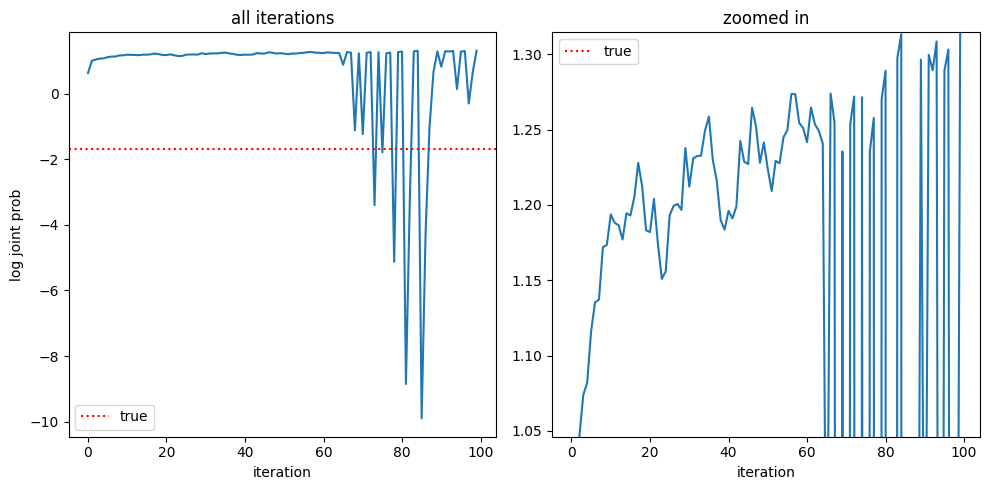

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lps / emissions.size)
axs[0].axhline(true_lp / emissions.size, color='r', ls=':', label='true')
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("log joint prob")
axs[0].set_title("all iterations")
axs[0].legend()

offset = 2
axs[1].plot(lps / emissions.size)
axs[1].axhline(true_lp / emissions.size, color='r', ls=':', label='true')
axs[1].set_xlabel("iteration")
axs[1].set_ylim(bottom=lps[offset] / emissions.size, top=lps.max() / emissions.size)
axs[1].set_title("zoomed in")
axs[1].legend()

plt.tight_layout()

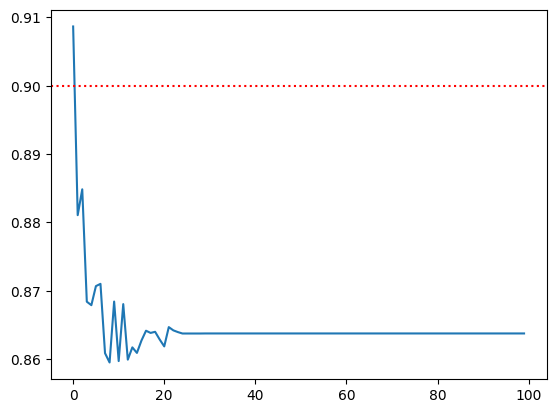

In [ ]:
plt.plot(posterior_samples_a0)
plt.axhline(sigmoid(true_model.logit_a_0), color='r', ls=':')

In [ ]:
plt.plot(posterior_samples_nu_a0)
plt.axhline(sigmoid(true_model.log_nu_a), color='r', ls=':')

Array([9.55473259e-02, 7.41889849e-02, 7.34961852e-02, 6.24357201e-02,
       6.40827790e-02, 5.78976385e-02, 5.56421243e-02, 4.95564677e-02,
       4.57760654e-02, 4.18728106e-02, 4.42385450e-02, 3.44570577e-02,
       3.10043115e-02, 3.14292200e-02, 2.90448125e-02, 2.40588132e-02,
       1.93116032e-02, 1.73324905e-02, 1.54380891e-02, 1.34523008e-02,
       1.19279074e-02, 8.34071916e-03, 5.05096698e-03, 3.64826713e-03,
       2.11663451e-03, 1.39737048e-03, 9.57232085e-04, 7.55815941e-04,
       4.83027019e-04, 3.70923866e-04, 3.00288084e-04, 1.70828163e-04,
       1.59401359e-04, 1.16000687e-04, 8.76949634e-05, 5.85022317e-05,
       4.53964240e-05, 3.91821486e-05, 3.01399687e-05, 2.07766243e-05,
       1.19559445e-05, 6.89181797e-06, 6.02179352e-06, 4.29452939e-06,
       3.34989477e-06, 2.51216829e-06, 1.67631595e-06, 1.24327187e-06,
       8.07231402e-07, 5.16704972e-07, 3.74273583e-07, 2.71714214e-07,
       1.61646085e-07, 1.23942968e-07, 6.26504360e-08, 6.15242683e-08,
      

### Compare last sample of states and params to true values

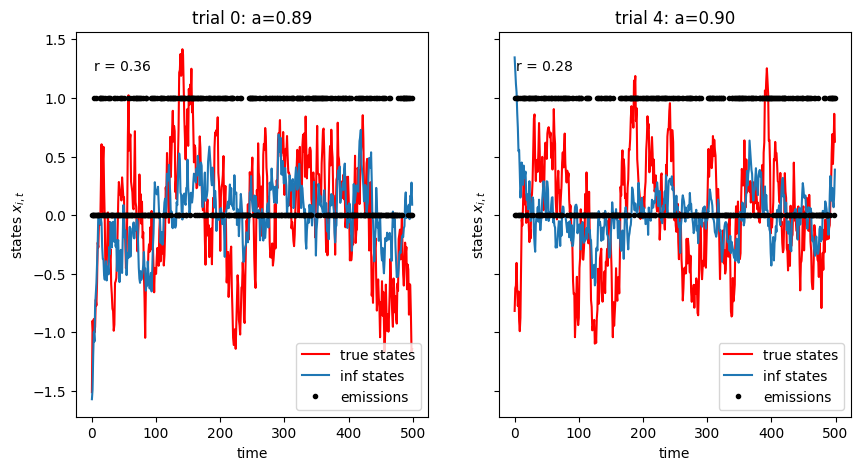

In [ ]:
# Plot a couple trials
# Idea: can we average the latent state for each subject over X last samples to get better estimates?


fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, ax in zip([0, 4], axs):
    ax.plot(true_states[i], c='r', label="true states")
    ax.plot(states[i], label="inf states")
    ax.plot(emissions[i], 'k.', label="emissions")
    ax.set_xlabel("time")
    ax.set_ylabel("states $x_{i,t}$")
    ax.legend(loc="lower right")
    r, p = spearmanr(true_states[i], states[i])
    ax.annotate('r = {:.2f}'.format(r), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=10)

    ax.set_title(r"trial {:d}: a={:.2f}".format(i, true_params["a"][i]))


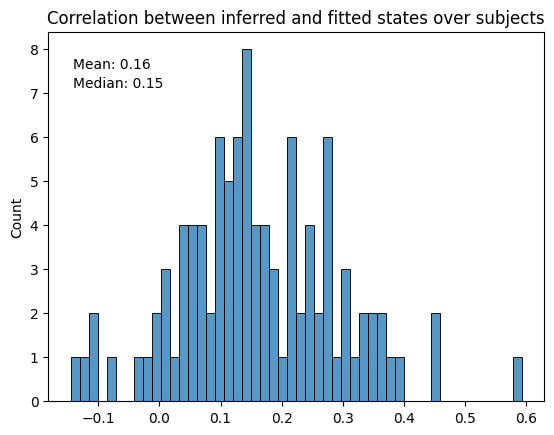

In [ ]:
# Plot correlation between true and inferred states for all subjects
correlations_inferred_and_fitted_states = []
for i in jnp.arange(len(emissions)):
    r, _= spearmanr(true_states[i], states[i])
    correlations_inferred_and_fitted_states.append(r)

correlations_inferred_and_fitted_states = jnp.array(correlations_inferred_and_fitted_states)

sns.histplot(data=correlations_inferred_and_fitted_states, bins=50)

mean_value = jnp.mean(correlations_inferred_and_fitted_states)
median_value = jnp.median(correlations_inferred_and_fitted_states)

plt.title("Correlation between inferred and fitted states over subjects")
plt.annotate(f'Mean: {mean_value:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
plt.annotate(f'Median: {median_value:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)

plt.show()



In [ ]:
# Plot 3 lowest/highest correlations between true and inferred states
def find_values_positions(my_list):
    # Enumerate the sorted list to keep track of original positions
    sorted_list_with_positions = sorted(enumerate(my_list), key=lambda x: x[1])

    # Extract the positions of the 3 lowest values
    lowest_positions = [index for index, _ in sorted_list_with_positions[:3]]
    highest_positions = [index for index, _ in sorted_list_with_positions[-3:]]
    return lowest_positions, highest_positions


lowest_positions, highest_positions = find_values_positions(correlations_inferred_and_fitted_states)

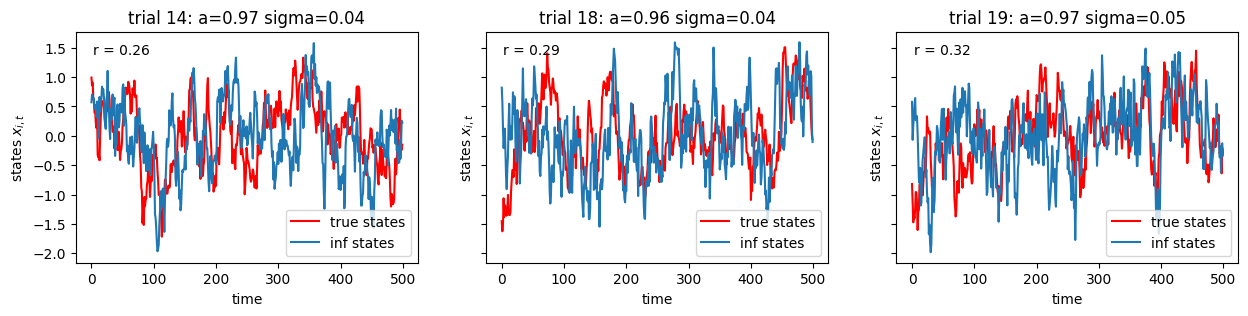

In [ ]:
# lowest
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

for i, ax in zip(lowest_positions, axs):
    ax.plot(true_states[i], c='r', label="true states")
    ax.plot(states[i], label="inf states")
    ax.set_xlabel("time")
    ax.set_ylabel("states $x_{i,t}$")
    ax.legend(loc="lower right")
    r, p = spearmanr(true_states[i], states[i])
    ax.annotate('r = {:.2f}'.format(r), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=10)
    ax.set_title(r"trial {:d}: a={:.2f} sigma={:.2f}".format(i, true_params["a"][i], true_params["sigmasq"][i]))

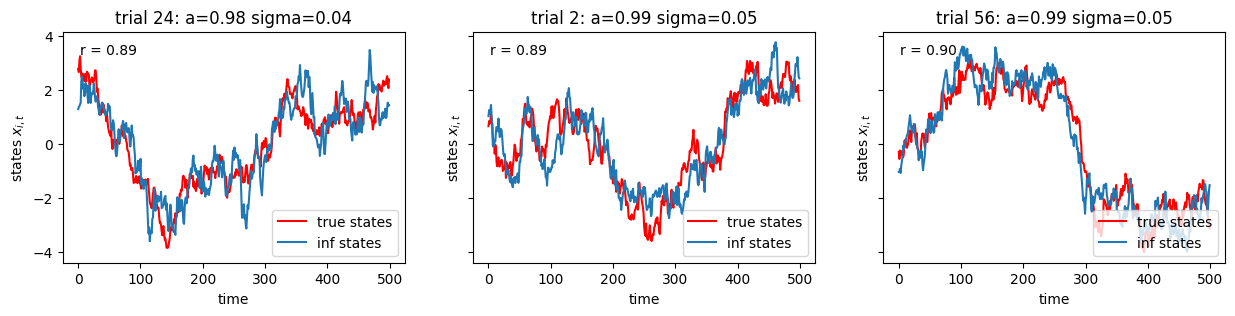

In [ ]:
# highest
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

for i, ax in zip(highest_positions, axs):
    ax.plot(true_states[i], c='r', label="true states")
    ax.plot(states[i], label="inf states")
    ax.set_xlabel("time")
    ax.set_ylabel("states $x_{i,t}$")
    ax.legend(loc="lower right")
    r, p = spearmanr(true_states[i], states[i])
    ax.annotate('r = {:.2f}'.format(r), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=10)
    ax.set_title(r"trial {:d}: a={:.2f} sigma={:.2f}".format(i, true_params["a"][i], true_params["sigmasq"][i]))

Unsurprisingly, we can't really infer the latent states when they're close to zero. This tends to happen when $a_i \ll 1$.

Text(0.5, 1.0, 'true and inferred states (from all trials)')

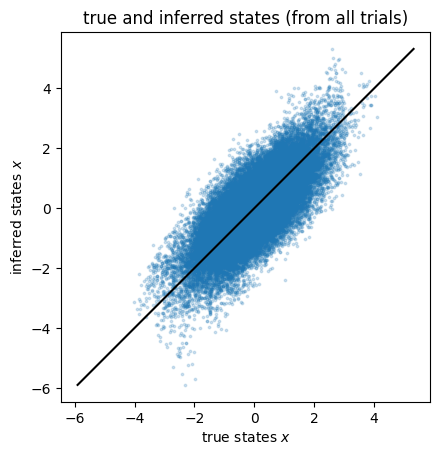

In [ ]:
# Now look at the true and inferred states across all trials
x_min = min(true_states.min(), states.min())
x_max = max(true_states.max(), states.max())

plt.scatter(true_states.ravel(), states.ravel(), s=3, alpha=0.2)
plt.xlabel("true states $x$")
plt.ylabel("inferred states $x$")
plt.plot([x_min, x_max], [x_min, x_max], '-k')
plt.gca().set_aspect(1.0)
plt.title("true and inferred states (from all trials)")

### Compare true and inferred (last sample) estimates of $a_i$

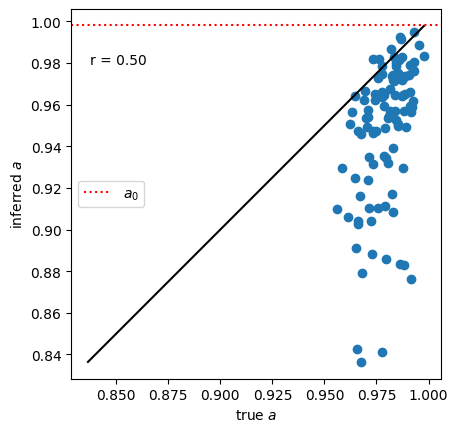

In [ ]:
a_min = min(true_params["a"].min(), params["a"].min())
a_max = max(true_params["a"].max(), params["a"].max())
plt.scatter(true_params["a"], params["a"])
plt.xlabel("true $a$")
plt.ylabel("inferred $a$")
plt.plot([a_min, a_max], [a_min, a_max], '-k')
plt.gca().set_aspect(1.0)
plt.axhline(sigmoid(model.logit_a_0), color='r', ls=':', label=r'$a_0$')
r, p = spearmanr(true_params["a"], params["a"])
plt.annotate('r = {:.2f}'.format(r), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
plt.legend()

Estimation of $a_i$ is best when the true value is close to 1. When $a_i \ll 1$, the dynamic range of $x_i$ is limited and we can't infer it accurately. As a result, we get high variance estimates of $a_i$ as well.

### Compare true and inferred (last sample) estimates of $w_i$

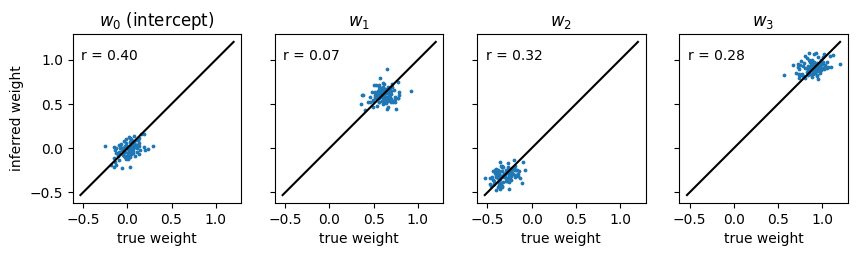

In [ ]:
w_min = min(true_params["w"].min(), params["w"].min())
w_max = max(true_params["w"].max(), params["w"].max())

fig, axs = plt.subplots(1, num_inputs, sharey=True, figsize=(10, 5))
for d, ax in enumerate(axs):
    ax.scatter(true_params["w"][:, d], params["w"][:,d], s=3)
    ax.set_xlabel(r"true weight")
    if d == 0: ax.set_ylabel(r"inferred weight")
    ax.plot([w_min, w_max], [w_min, w_max], '-k')
    ax.set_aspect(1.0)
    ax.set_title(r"$w_{:d}$".format(d))
    if d == 0: ax.set_title("$w_0$ (intercept)")
    r, p = spearmanr(true_params["w"][:, d], params["w"][:,d])
    ax.annotate('r = {:.2f}'.format(r), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)


### Compare true and inferred (last sample) estimates of $w_0$

This is important for hypothesis testing

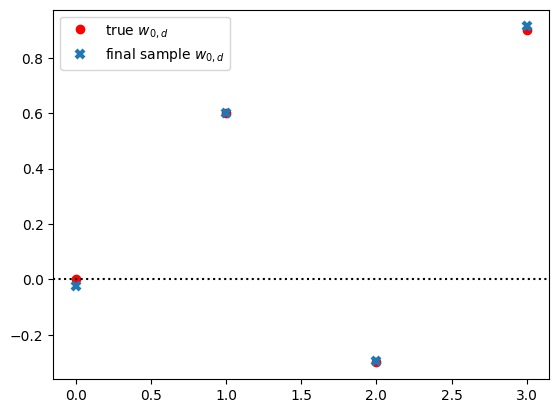

In [ ]:
plt.plot(true_model.w_0, 'ro', label="true $w_{0,d}$")
plt.plot(model.w_0, 'x', mew=3, label="final sample $w_{0,d}$")
plt.axhline(0, color='k', ls=':')
plt.legend()

In [ ]:
print("true nu_w:       ", jnp.exp(true_model.log_nu_w))
print("last sample nu_w:", jnp.exp(model.log_nu_w))

true nu_w:        0.1
last sample nu_w: 0.075070806


### Compare true and inferred (last sample) estimates of $\varsigma_i^2$

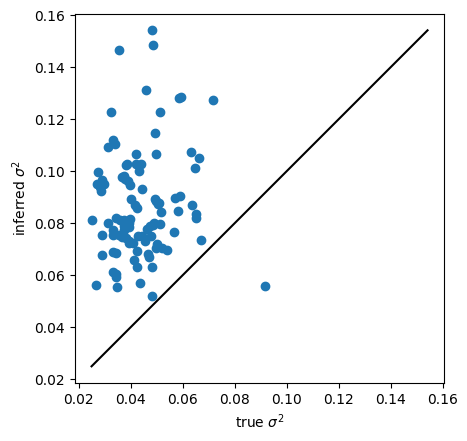

In [ ]:
sigmasq_min = min(true_params["sigmasq"].min(), params["sigmasq"].min())
sigmasq_max = max(true_params["sigmasq"].max(), params["sigmasq"].max())

plt.scatter(true_params["sigmasq"], params["sigmasq"])
plt.xlabel(r"true $\sigma^2$")
plt.ylabel(r"inferred $\sigma^2$")
plt.plot([sigmasq_min, sigmasq_max], [sigmasq_min, sigmasq_max], '-k')
plt.gca().set_aspect(1.0)

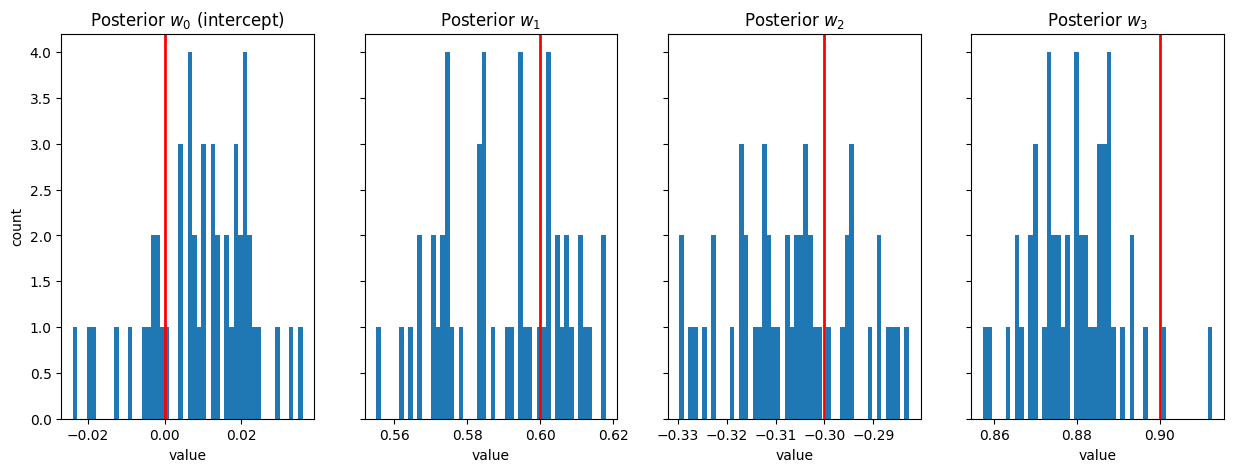

In [ ]:
burn_in = 50 # number of iterations to discard for posterior distributions


fig, axs = plt.subplots(1, num_inputs, sharey=True, figsize=(15, 5))
for d, ax in enumerate(axs):
    ax.hist(posterior_samples_w[burn_in:,d], bins=50)
    ax.axvline(x=true_model.w_0[d], color='r', linewidth=2)
    ax.set_xlabel(r"value")
    if d == 0: ax.set_ylabel(r"count")
    ax.set_title(r"Posterior $w_{:d}$".format(d))
    if d == 0: ax.set_title("Posterior $w_0$ (intercept)")

plt.show()

## Parameter recovery with multiple datasets

In [ ]:
# Sample multiple datasets
num_iters = 100
num_inputs = 4
num_trials = 100
num_timesteps = 500
w0 = jnp.array([0.0, 0.6, -0.3, 0.9])       # Generate data with nonzero mean effects
nu_w = 1.0
true_model = HierarchicalBernoulliLDS(0.98, 0.01, w0, nu_w, 20.0, 20.0 * 0.2**2)

num_datasets = 2
seed = jnp.arange(num_datasets)


def simulate_one_dataset(key):

    inputs = tfd.Normal(0, 1).sample(sample_shape=(num_trials, num_timesteps, num_inputs), seed=key)
    inputs = inputs.at[:, :, 0].set(1.0)
    true_params, true_states, emissions = true_model.sample(key, inputs)
    masks = jnp.ones_like(emissions)

    return true_params, true_states, emissions, inputs, masks


def simulate_and_fit_model(keys):
    key = jr.PRNGKey(keys)

    # Sample dataset
    true_params, true_states, emissions, inputs, masks = simulate_one_dataset(key)

    # Initialize model
    model = HierarchicalBernoulliLDS(0.98, 0.01, jnp.zeros(num_inputs), 1.0, 20.0, 20.0 * 0.2**2)
    params, states, _ = model.sample(key, inputs)

    # Fit model
    lps = []
    posterior_samples_w = []

    for itr in progress_bar(range(num_iters)):
        this_key, key = jr.split(key)
        lp, states, params, model = gibbs_step(this_key, emissions, masks, states, inputs, params, model)
        lps.append(lp)
        posterior_samples_w.append(model.w_0)

    lps = jnp.stack(lps)
    posterior_samples_w = jnp.stack(posterior_samples_w)

    return true_params, true_states, params, states, emissions, inputs, lps, posterior_samples_w, model.w_0

all_true_params, all_true_states, all_inf_params, all_inf_states, all_emissions, all_inputs, all_lps, all_posterior_samples_w, all_hyperparams = vmap(simulate_and_fit_model)(seed)



r, p = spearmanr(all_true_params['w'][0][1], all_inf_params['w'][0][1])

## Conclusion

Looks like it's working in simulation!

This to do/try:
- [ ] The code allows you to provide a mask for variable length trials, but I haven't tested it.
- [x] We also need to update the global parameters $\eta$
    - Perhaps the simplest way to do so would be moment matching to the current samples $\{\theta_i\}_{i=1}^N$.
    - Can we get a good MoM estimator for the truncated normal? Maybe we just ignore the truncation, which would lead to slightly biased estimates.
    - Alternatively, we could place uninformative priors on the global params and use HMC or something.
    - **Update: I think we've settled on a good solution: compute a posterior distribution over $w_0$ and $\nu_w^2$, but treat the other global parameters as fixed. We can use the samples of $w_0$ to compute posterior credible intervals.**
- [ ] I think the bottleneck is the PG sampling step. There are much faster algorithms for sampling PG(1,c) random variables, but they're a pain to implement. I can do it, but it would take time and may not be worth it at the moment.
- [ ] The analyses at the end of this notebook just look at the last sample of the states and parameters. We should really consider the last $M$ samples as an approximation of the posterior distribution.
